In [25]:
%%capture
##############################################################################
# IGNORE if you are running on a local machine and have all the dependencies #
##############################################################################

# installing dependencies --- to be able to run on google colab
# it would take 2-3 minutes

!yes | pip3 uninstall pandas
!yes | pip3 uninstall geopandas

!apt-get install libspatialindex-c4v5;
!pip3 install Rtree;
!pip3 install osmnx;
!pip3 install tqdm;
!pip3 install ipyleaflet;
!pip3 install pandas
!pip3 install geopandas
!pip3 install matplotlib
!pip3 install osmapi
!pip3 install geopy
!pip3 install plotly
!pip3 install folium

In [26]:
import osmnx as ox
from ipyleaflet import *
import networkx as nx
import plotly.graph_objects as obj
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import osmapi as osm
import time
from collections import deque
from tqdm import tqdm
from itertools import islice

In [3]:
!unzip /content/utilities.zip # only need to do this when running through Collab

Archive:  /content/utilities.zip
ec68c57f03f6058b04cfe8c1108e65923c57b776
   creating: utilities-ec68c57f03f6058b04cfe8c1108e65923c57b776/
   creating: utilities-ec68c57f03f6058b04cfe8c1108e65923c57b776/.github/
   creating: utilities-ec68c57f03f6058b04cfe8c1108e65923c57b776/.github/ISSUE_TEMPLATE/
  inflating: utilities-ec68c57f03f6058b04cfe8c1108e65923c57b776/.github/ISSUE_TEMPLATE/bug_report.md  
  inflating: utilities-ec68c57f03f6058b04cfe8c1108e65923c57b776/.gitignore  
  inflating: utilities-ec68c57f03f6058b04cfe8c1108e65923c57b776/LICENSE  
  inflating: utilities-ec68c57f03f6058b04cfe8c1108e65923c57b776/README.md  
  inflating: utilities-ec68c57f03f6058b04cfe8c1108e65923c57b776/__init__.py  
   creating: utilities-ec68c57f03f6058b04cfe8c1108e65923c57b776/src/
  inflating: utilities-ec68c57f03f6058b04cfe8c1108e65923c57b776/src/__init__.py  
  inflating: utilities-ec68c57f03f6058b04cfe8c1108e65923c57b776/src/common.py  
  inflating: utilities-ec68c57f03f6058b04cfe8c1108e65923c57b7

In [27]:
from utilities import *

# Start of Graph Formulation

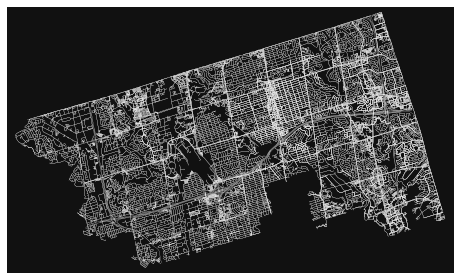

In [28]:
place = 'North York, Ontario, Canada'
G = ox.graph_from_place(place)
fig, ax = ox.plot_graph(G, node_size=0, edge_color='w', edge_linewidth=0.2)  # display the city of North York 

In [29]:
nodes, edges = ox.graph_to_gdfs(G)      # Convert node and edge GeoDataFrames to a MultiDiGraph.

# [Depreciated - will be removed] Option 1: Using Nominatim API

Based on the analysis it does not pickout many points. We can go with option 2 for now. 


In [1]:
class Amenity: 
  def __init__(self, amenity, lat, lon, address):
    self.amenity = amenity
    self.lat = float(lat)
    self.lon = float(lon)
    self.address = address
    self.coordinates = (float(lon), float(lat))

In [2]:
amenities = []

firestation_link = 'https://nominatim.openstreetmap.org/?addressdetails=1&q=fire+stations+in+north+york&format=json'
hospitals_link = 'https://nominatim.openstreetmap.org/?addressdetails=1&q=hospitals+in+north+york&format=json'

links = [firestation_link, hospitals_link]

for link in links:  
  response = requests.get(link)

  if response.status_code != 200:
      raise ValueError("We couldn't decode the address, please make sure you entered it correctly")

  response_json = response.json()

  for place in response_json:
    amenities.append(Amenity(place['type'], place['lat'], place['lon'], place['display_name']))
    # print(place['type'], place['display_name'], place['lat'], place['lon'])

NameError: ignored

In [ ]:
critical_amenity_nodes = []
# nc = ['w'] * len(nodes)
# ns = [10 if node in amenities else 0 for node in G.nodes()]

for place in amenities:
  point = (place.lat, place.lon) # lat (y), lon (x) 
  pt_nearest_node_euc = ox.get_nearest_node(G, point, method='euclidean')
  critical_amenity_nodes.append((pt_nearest_node_euc, place.amenity))


In [ ]:
def node_color_and_size(critical_nodes, nodes):
  node_colors = ['w'] * len(nodes)
  node_size = [0] * len(nodes)
  for place in critical_nodes: 
    idx = nodes.index(place[0])
    if (place[1] == 'fire_station'):
      node_colors[idx] = 'b'
    elif (place[1] == 'hospital'):
      node_colors[idx] = 'r'
    node_size[idx] = 10
  return node_colors, node_size

print(critical_amenity_nodes)

In [ ]:
all_nodes = list(nodes.to_dict()['osmid'].keys())
nc, ns = node_color_and_size(critical_amenity_nodes, all_nodes)

fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, edge_linewidth=0.2, bgcolor = 'white')

# Option 2/2: Using OpenStreetMap node IDs API

This highlights many amenities. Seems to be a good option here.

In [30]:
class Amenity: 
  def __init__(self, amenity, lat, lon, name, osmid, nearestNode):
    self.amenity = amenity
    self.lat = float(lat)
    self.lon = float(lon)
    self.name = name
    self.osmid = osmid 
    self.nearestNode = nearestNode

In [33]:
# Get all the important things we need to highlight on the map
tags = {
    'amenity':['hospital', 'fire_station'],
}
emergency_locations = ox.geometries_from_place(place, tags=tags)
print(emergency_locations)
df = pd.DataFrame(emergency_locations)  # data frame 
dic = df.to_dict()

          unique_id       osmid element_type       amenity  \
0    node/609290577   609290577         node  fire_station   
1   node/1601962650  1601962650         node  fire_station   
2      way/27006473    27006473          way      hospital   
3      way/31372887    31372887          way  fire_station   
4      way/43806314    43806314          way  fire_station   
5      way/60428611    60428611          way  fire_station   
6      way/68021042    68021042          way  fire_station   
7     way/108700348   108700348          way  fire_station   
8     way/109199283   109199283          way  fire_station   
9     way/111664202   111664202          way  fire_station   
10    way/120882312   120882312          way  fire_station   
11    way/124105159   124105159          way  fire_station   
12    way/130468302   130468302          way  fire_station   
13    way/134818544   134818544          way  fire_station   
14    way/134823356   134823356          way  fire_station   
15    wa

In [34]:
amenities = []

api = osm.OsmApi() # using this to find lat and lon
for i in range(len(dic['unique_id'])):
  if ("node" in dic['unique_id'][i]):
    nodeId= dic['osmid'][i]
  elif ("way" in dic['unique_id'][i]):
    nodeId = dic['nodes'][i][0]

  id_info = api.NodeGet(nodeId)
  point = (id_info['lat'], id_info['lon']) # lat (y), lon (x) 
  pt_nearest_node_euc = ox.get_nearest_node(G, point, method='euclidean')
  
  # amenity, lat, lon, name, osmid, nearestNode
  amenities.append(Amenity(dic['amenity'][i], id_info['lat'], id_info['lon'], 
                           dic['name'][i], dic['osmid'][i], pt_nearest_node_euc))
  

In [35]:
def find_element_in_list(element, list_element):
    try:
        index_element = list_element.index(element)
        return index_element
    except ValueError:
        return -1

def node_color_and_size(amenities, nodes):
  node_colors = ['w'] * len(nodes)
  node_size = [0] * len(nodes)
  for i in range(len(amenities)): 
    idx = find_element_in_list(amenities[i].nearestNode, nodes)
    if (idx != -1):
      if (amenities[i].amenity == 'fire_station'):
        node_colors[idx] = 'b'
      if (amenities[i].amenity == 'hospital'):
        node_colors[idx] = 'r'
      node_size[idx] = 10
  return node_colors, node_size

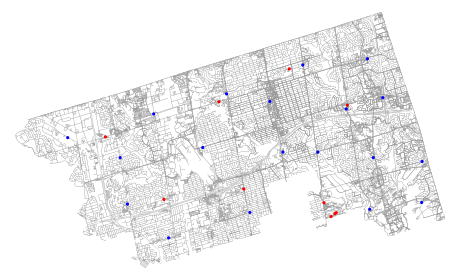

In [36]:
all_nodes = list(nodes.to_dict()['osmid'].keys())
nc, ns = node_color_and_size(amenities, all_nodes)

fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, edge_linewidth=0.2, bgcolor = 'white')

Stategy going forward: 
1. Heat map of traafic data 
2. Implement the algorithm - currently we are utilizing the algorithm from prof

# The Algorithm

## -------- A* -----------

In [37]:
# first define the origin/source nodes as Node
# origin = Node(graph = G, osmid = amenities[0].nearestNode)
# destination = Node(graph = G, osmid = amenities[3].nearestNode)

In [38]:
def A_star(G, origin, destination):
    toGoal, toDestination = astar_heuristic(G, origin.osmid, destination.osmid)

    %time
    route = []
    frontier = list()

    bar = tqdm(total=len(G)) # for the progress bar

    frontier.append(origin)
    explored = set()
    found = False

    while frontier and not found:
        bar.update(1); time.sleep(0.05)

        # choose a node based on its heuristic value
        node = min(frontier, key = lambda node : toGoal[node.osmid] + toDestination[node.osmid])
        frontier.remove(node)
        explored.add(node)

        # expand its children
        for child in node.expand():
            if child not in explored and child not in frontier:
                if child == destination:
                    route = child.path()
                    found = True
                    continue
                frontier.append(child)

    bar.close()
    return route 

In [39]:
to_from_locations = []
to_from_locations.append( (Node(graph = G, osmid = amenities[0].nearestNode), 
                           Node(graph = G, osmid = amenities[3].nearestNode)))
to_from_locations.append( (Node(graph = G, osmid = amenities[1].nearestNode), 
                           Node(graph = G, osmid = amenities[4].nearestNode)))
to_from_locations.append( (Node(graph = G, osmid = amenities[2].nearestNode), 
                           Node(graph = G, osmid = amenities[7].nearestNode)))

routes = []

for i in range(len(to_from_locations)):
    routes.append(A_star(G, to_from_locations[i][0], to_from_locations[i][1]))
    

  0%|          | 3/35529 [00:00<19:49, 29.86it/s]

CPU times: user 6 µs, sys: 0 ns, total: 6 µs
Wall time: 10.3 µs


  0%|          | 3/35529 [00:00<19:50, 29.84it/s]

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 10.3 µs


  0%|          | 3/35529 [00:00<19:51, 29.81it/s]

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 14.8 µs


  2%|▏         | 748/35529 [00:38<29:37, 19.57it/s]


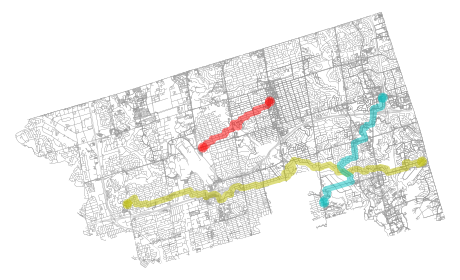

In [40]:
rc = ['r', 'y', 'c']

fig, ax = ox.plot_graph_routes(G, routes, route_colors=rc, route_linewidth=6, node_size=0, edge_linewidth=0.2, bgcolor = 'white')


--------------------------------------------------------------------------

# **TESTING ONWARDS** - Ignore